### Exercise 4.7
*Note: Full problem takes too long to run. Shrinking then problem size in the actual implementation (not doing part 2)*

The key for this exercise is to calculate the dynamic $p(s', r| s, a)$ efficiently.  
Given $s,a,r,s'$, denote the number of cars requests as $x$ and number of cars returns as $y$. 

We will work from bottom up, looping all possible $s,a, x, y$ combinations and update the $(s',r, s, a)$ table. Note that 
$$ r = -2 a +  10 \max(0, \min(20, s \pm a) - x),$$

$$ s' = \min(20, \max(0, \min(20, s \pm a) - x) + y) $$

where $\ -\max(s_2, 5) \leq a \leq \min(s_1, 5), \ \ \ x\in [0,\infty] \ \ \ y \in [0,\infty]$

Note that $x,y$ are poisson which has domain of $[0, \infty]$, when we calculate the probability, we will collapse the infinite domain such that $$p(x < s - a) = pmf(x)$$ , $$p(x = s - a) = 1 - cdf(max(0, s - a - 1))$$ and $$p(x > s - a) = 0$$

For efficiency, to store the transition probability, we will use nested dictionary keying on $s \rightarrow a \rightarrow (s', r)$ 

Note that for each location, the rental and return requests are independent, meaning the probability of $(x,y)$ occuring is $p(x_1)p(x_2)p(y_1)p(y_2)$. Poisson pmf drops close to 0 very fast with $x$ increasing and the product of the 4 will make it even closer to 0 fast. Therefore we can prune range of $x$ and $y$ down to finite. 


In [623]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import namedtuple
from numpy.random import default_rng
from scipy.stats import poisson
rng = default_rng()

In [473]:
df = pd.DataFrame()
df["lam=2"] = poisson.pmf(np.arange(20), 2)
df["lam=3"] = poisson.pmf(np.arange(20), 3)
df["lam=4"] = poisson.pmf(np.arange(20), 4)
df = df.applymap("{:.1%}".format)
df

,lam=2,lam=3,lam=4
0,13.5%,5.0%,1.8%
1,27.1%,14.9%,7.3%
2,27.1%,22.4%,14.7%
3,18.0%,22.4%,19.5%
4,9.0%,16.8%,19.5%
5,3.6%,10.1%,15.6%
6,1.2%,5.0%,10.4%
7,0.3%,2.2%,6.0%
8,0.1%,0.8%,3.0%
9,0.0%,0.3%,1.3%


Above is the plot of poisson pmf over the integers, notice that the probability quickly drop to near 0. We will prune the the 3 columns up to row (5, 6, 7).

In [688]:
class JackRentalEnv:
    def __init__(self):
        self.MAX_A = 2
        self.MAX_S = 8
        self.LAM_X_1 = 2
        self.LAM_X_2 = 3
        self.LAM_Y_1 = 2
        self.LAM_Y_2 = 1
        self.pois = {}
        self.transition = {}
        self.loc1_table = {}
        self.loc2_table = {}
        self.state_table = {}
        
    def build_pois_table(self):
        self.pois_pmf = {}
        self.pois_cdf = {}
        for cnt in range(self.MAX_S + 1):
            for lam in [self.LAM_X_1, self.LAM_X_2, self.LAM_Y_2]:
                if cnt == self.MAX_S:
                    self.pois_pmf[(cnt, lam)] = 1 - poisson.cdf(cnt-1, lam)
                else:
                    self.pois_pmf[(cnt, lam)] = poisson.pmf(cnt, lam)
            
    
    def build_transition_table(self):
        s_range = range(self.MAX_S+1)
        for (s1, s2) in product(s_range, s_range):
            for a in range(-min(s2, self.MAX_A), min(s1, self.MAX_A) + 1):
                for (x1, x2) in product(s_range, s_range):
                    for (y1, y2) in product(s_range, s_range):
                        sp1 = min(self.MAX_S, max(0, min(self.MAX_S, s1 - a) - x1) + y1)
                        sp2 = min(self.MAX_S, max(0, min(self.MAX_S, s2 + a) - x2) + y2)
                        r = -2 * a + min(s1 - a, x1) * 10 + min(s2 + a, x2) * 10
                        if (s1, s2) not in self.state_table:
                            self.state_table[(s1, s2)] = {}
                        if a not in self.state_table[(s1, s2)]:
                            self.state_table[(s1, s2)][a] = {}
                        if (sp1, sp2, r) not in self.state_table[(s1, s2)][a]:
                            self.state_table[(s1, s2)][a][(sp1, sp2, r)] = 0

                        self.state_table[(s1, s2)][a][(sp1, sp2, r)] += (
                            self.pois_pmf[(x1, self.LAM_X_1)] * self.pois_pmf[(y1, self.LAM_Y_1)] * 
                            self.pois_pmf[(x2, self.LAM_X_2)] * self.pois_pmf[(y2, self.LAM_Y_2)])
        
    def table_size(self, table):
        size = 0
        for k in table:
            for k1 in table[k]:
                for k2 in table[k][k1]:
                    size += 1
        return size

    def prune_prob(self, table):
        to_remove = []
        for k in table:
            for k1 in table[k]:
                for k2 in table[k][k1]:
                    if table[k][k1][k2] < 0.005:
                        to_remove.append((k, k1, k2))
        
        for e in to_remove:
            del table[e[0]][e[1]][e[2]]
        

In [689]:
env = JackRentalEnv()
env.build_pois_table()

In [690]:
env.build_transition_table()

In [691]:
print(env.table_size(env.state_table))
# env.prune_prob(env.state_table)
print(env.table_size(env.state_table))

178569
178569


In [692]:
def plot_contour(Z, itr):
    x = np.arange(0, Z.shape[0], 1)
    y = np.arange(0, Z.shape[1], 1)
    X, Y = np.meshgrid(x, y)
    plt.figure(itr)
    contour = plt.contour(X,Y,Z, nchunk=20)
    plt.clabel(contour, contour.levels, inline=True, fmt=lambda x: f"{int(x):1d}", fontsize=10)
    
def pi_eval(v, pi, gamma, tolerance, env):
    delta = 0.0
    for s1 in range(env.MAX_S + 1):
        for s2 in range(env.MAX_S + 1):
            v_current, a, v_p = v[s1, s2], pi[s1, s2], 0
            if a in env.state_table[(s1, s2)]:
                for (sp1, sp2, r) in env.state_table[(s1, s2)][a]:
                    p = env.state_table[(s1, s2)][a][(sp1, sp2, r)]
                    v_p += (p * (r + gamma * v[sp1, sp2]))
            v[s1, s2] = v_p
            delta = max(delta, np.absolute(v_current - v[s1, s2]))
    if delta < tolerance:
        return True
    
def pi_improve(v, pi, gamma, env):
    pi_stable = True
    for s1 in range(env.MAX_S + 1):
        for s2 in range(env.MAX_S + 1):
            old_a = pi[s1, s2]
            argm, m = [],  -np.Inf
            for a in env.state_table[(s1, s2)]:
                tmp_v = 0 
                for (sp1, sp2, r) in env.state_table[(s1, s2)][a]:
                    p = env.state_table[(s1, s2)][a][(sp1, sp2, r)]
                    tmp_v += (p * (r + gamma * v[sp1, sp2]))
                if tmp_v > m:
                    m = tmp_v
                    argm = [a]
                elif tmp_v == m:
                    argm.append(a)
            pi[s1, s2] = int(argm[0])
            if old_a not in argm:
                pi_stable = False

    return pi_stable

def run_sim(env):
    pi = np.zeros(shape=(env.MAX_S + 1, env.MAX_S + 1), dtype=np.int8)
    v = np.zeros(shape=(env.MAX_S + 1, env.MAX_S + 1), dtype=np.float64)
    tolerance = 1e-4
    gamma = 0.9
    # policy evaluation
    for itr in range(5):
        plot_contour(pi, itr)

        # policy evaluation
        v_stable = False
        while not v_stable:
            v_stable = pi_eval(v, pi, gamma, tolerance, env)
                
        # policy improvement
        pi_stable = pi_improve(v, pi, gamma, env)
        
        if pi_stable:
            break;
        
    return (v, pi)
    
            

<ipython-input-692-81058e2cd3ca>:6: UserWarning: No contour levels were found within the data range.
  contour = plt.contour(X,Y,Z, nchunk=20)


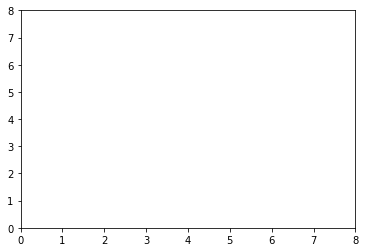

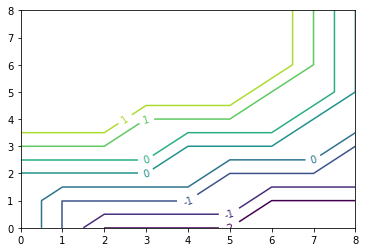

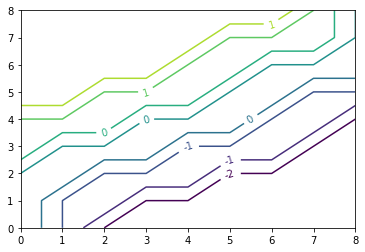

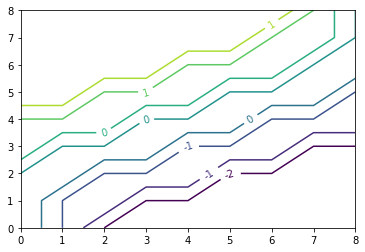

In [693]:
(v, policy) = run_sim(env)

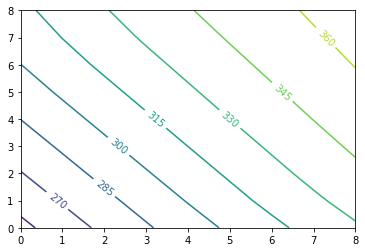

In [694]:
plot_contour(v, 10)

In [696]:
policy

array([[ 0, -1, -2, -2, -2, -2, -2, -2, -2],
       [ 0, -1, -1, -2, -2, -2, -2, -2, -2],
       [ 0,  0, -1, -1, -1, -2, -2, -2, -2],
       [ 1,  0,  0,  0, -1, -1, -1, -2, -2],
       [ 1,  1,  1,  0,  0,  0, -1, -1, -1],
       [ 2,  2,  1,  1,  1,  0,  0,  0, -1],
       [ 2,  2,  2,  2,  1,  1,  1,  0,  0],
       [ 2,  2,  2,  2,  2,  2,  1,  1,  0],
       [ 2,  2,  2,  2,  2,  2,  2,  1,  0]], dtype=int8)